
Plotting ts_slope_0_X for all current expirations...


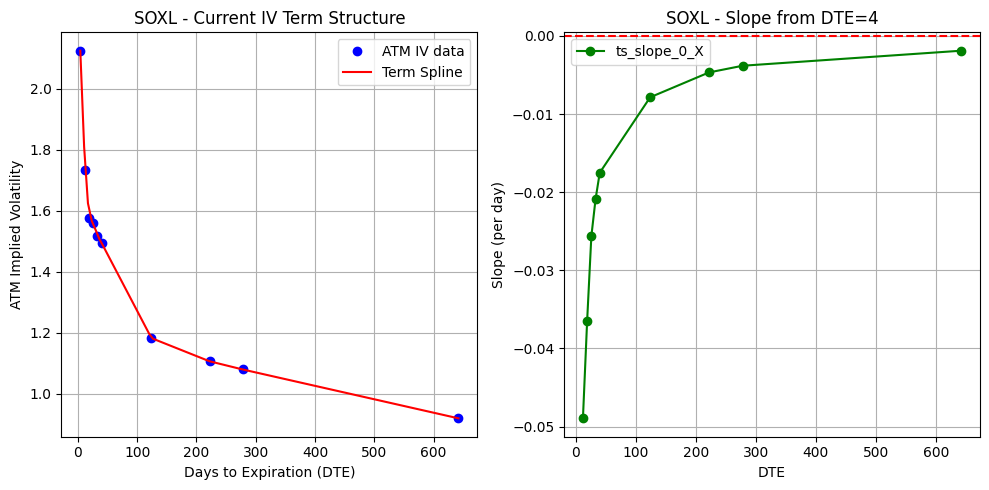

In [4]:
"""
DISCLAIMER:

This software is provided solely for educational and research purposes.
It is not intended to provide investment advice, and no investment
recommendations are made herein. The developers are not financial
advisors and accept no responsibility for any financial decisions or
losses resulting from the use of this software. Always consult a
professional financial advisor before making any investment decisions.
"""

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.interpolate import interp1d

###############################################################################
#                      PART 1: Core Computations & Helpers                    #
###############################################################################

def yang_zhang(price_data, window=30, trading_periods=252):
    """
    Compute Yang-Zhang volatility (annualized).
    price_data: DataFrame with columns ['Open','High','Low','Close']
    window: rolling window for realized volatility
    trading_periods: number of trading days (annualization factor)
    Returns a Series of length len(price_data)-window+1 (NaNs at start).
    """
    price_data = price_data.dropna(subset=['Open','High','Low','Close'])
    log_ho = np.log(price_data['High'] / price_data['Open'])
    log_lo = np.log(price_data['Low']  / price_data['Open'])
    log_co = np.log(price_data['Close']/ price_data['Open'])
    
    log_oc = np.log(price_data['Open']/ price_data['Close'].shift(1))
    log_cc = np.log(price_data['Close']/ price_data['Close'].shift(1))

    log_oc_sq = log_oc**2
    log_cc_sq = log_cc**2

    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)

    close_vol = (
        log_cc_sq.rolling(window=window).sum() * (1.0 / (window - 1.0))
    )
    open_vol = (
        log_oc_sq.rolling(window=window).sum() * (1.0 / (window - 1.0))
    )
    window_rs = (
        rs.rolling(window=window).sum() * (1.0 / (window - 1.0))
    )

    k = 0.34 / (1.34 + ((window + 1) / (window - 1)) )
    yz = (open_vol + k * close_vol + (1 - k) * window_rs).apply(np.sqrt)
    yz_annualized = yz * np.sqrt(trading_periods)
    
    return yz_annualized

def build_term_structure(days, ivs):
    """
    Given a list/array of DTEs ('days') and at-the-money
    implied volatilities ('ivs'), build a linear spline
    for quick interpolation.
    """
    days = np.array(days)
    ivs  = np.array(ivs)

    # sort by ascending DTE
    sort_idx = days.argsort()
    days = days[sort_idx]
    ivs  = ivs[sort_idx]

    spline = interp1d(days, ivs, kind='linear', fill_value="extrapolate")

    def term_spline(dte):
        if dte < days[0]:
            return float(ivs[0])
        elif dte > days[-1]:
            return float(ivs[-1])
        else:
            return float(spline(dte))

    return term_spline


###############################################################################
#                 PART 2: Hypothetical Historical IV30 Retrieval             #
###############################################################################
def get_historical_iv30(ticker, date):
    """
    Placeholder function to retrieve historical "iv30" for a given ticker
    and date. This is NOT supported by 'yfinance' free API in real life.

    If you had a historical options database, you would:
    1. Pull the entire option chain for 'date'.
    2. Find the at-the-money implied vol for ~30 DTE.
    3. Return that value.

    For demonstration, we'll just return a random-ish number,
    or you can feed your own historical data here.
    """
    # This is just a placeholder or stub.
    # Real implementation would query a historical data source or database.
    # e.g. random "simulated" value for demonstration:
    rng = np.random.RandomState(abs(hash(ticker + str(date))) % 1234567)
    # Return something between 0.20 and 0.60
    return 0.20 + 0.40 * rng.rand()


###############################################################################
#       PART 4: Plotting ts_slope_0_X for All Current Future Expirations      #
###############################################################################
def plot_ts_slope_0_X(ticker):
    """
    Pulls the *current* option chain from yfinance, builds an IV term structure
    for all available expirations, and plots:
      1) The actual implied vol points vs. DTE
      2) The slope from the earliest expiration to each later expiration.
    """

    stock = yf.Ticker(ticker)

    # Grab all current expiration dates from yfinance
    all_expirations = stock.options

    if not all_expirations:
        print(f"No option data for {ticker}")
        return

    # Build a dictionary of (exp_date -> ATM IV)
    atm_ivs   = {}
    today     = datetime.today().date()

    # We'll do a quick loop over all expirations
    for exp_date_str in all_expirations:
        exp_dt = datetime.strptime(exp_date_str, "%Y-%m-%d").date()
        try:
            chain = stock.option_chain(exp_date_str)
        except:
            continue

        calls = chain.calls
        puts  = chain.puts

        if calls.empty or puts.empty:
            continue

        # Underlying's current price
        hist = stock.history(period='1d')
        if 'Close' not in hist.columns or hist.empty:
            continue
        underlying_price = hist['Close'].iloc[-1]

        # Find the near-ATM strikes
        calls['diff'] = (calls['strike'] - underlying_price).abs()
        puts['diff']  = (puts['strike']  - underlying_price).abs()
        call_idx = calls['diff'].idxmin()
        put_idx  = puts['diff'].idxmin()

        # Average of call/put IV near ATM
        call_iv = calls.loc[call_idx, 'impliedVolatility']
        put_iv  = puts.loc[put_idx,  'impliedVolatility']
        atm_iv  = (call_iv + put_iv) / 2.0

        dte = (exp_dt - today).days
        atm_ivs[dte] = atm_iv

    if not atm_ivs:
        print(f"No ATM IV data found for {ticker}")
        return

    # Sort by ascending DTE
    dte_sorted = sorted(atm_ivs.keys())
    ivs_sorted = [atm_ivs[d] for d in dte_sorted]

    # Build the term structure function
    term_spline = build_term_structure(dte_sorted, ivs_sorted)

    # We'll define the "front" expiration as the earliest in the list
    if len(dte_sorted) < 2:
        print(f"Not enough expirations to measure slope for {ticker}")
        return

    front_dte = dte_sorted[0]
    front_iv  = term_spline(front_dte)

    # 1) Plot the actual IV points vs DTE
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.plot(dte_sorted, ivs_sorted, 'bo', label='ATM IV data')
    # Also overlay the interpolation
    dense_dtes = np.linspace(min(dte_sorted), max(dte_sorted), 100)
    dense_ivs  = [term_spline(d) for d in dense_dtes]
    plt.plot(dense_dtes, dense_ivs, 'r-', label='Term Spline')
    plt.title(f"{ticker} - Current IV Term Structure")
    plt.xlabel("Days to Expiration (DTE)")
    plt.ylabel("ATM Implied Volatility")
    plt.grid(True)
    plt.legend()

    # 2) Plot the slope from earliest expiration to each future expiration
    #    slope(dte) = [IV(dte) - IV(front_dte)] / (dte - front_dte)
    slopes = []
    for d in dte_sorted[1:]:
        slope_val = (term_spline(d) - front_iv) / (d - front_dte) if (d - front_dte) != 0 else np.nan
        slopes.append((d, slope_val))

    slope_dtes   = [s[0] for s in slopes]
    slope_values = [s[1] for s in slopes]

    plt.subplot(1,2,2)
    plt.plot(slope_dtes, slope_values, 'g-o', label='ts_slope_0_X')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title(f"{ticker} - Slope from DTE={front_dte}")
    plt.xlabel("DTE")
    plt.ylabel("Slope (per day)")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


###############################################################################
#                              PART 5: Demo Main                              #
###############################################################################
if __name__ == "__main__":
    ticker_symbol = "SOXL"

    print("\nPlotting ts_slope_0_X for all current expirations...")
    plot_ts_slope_0_X(ticker_symbol)
